In [6]:
import numpy as np
import pandas as pd
from skopt import gp_minimize, gbrt_minimize 
from skopt.plots import plot_convergence, plot_objective
from rl4greencrab.envs.green_crab_monthly_env import greenCrabMonthEnv
from rl4greencrab.envs.green_crab_monthly_env_norm import greenCrabMonthEnvNormalized
from rl4greencrab.envs.time_series import timeSeriesEnv
from rl4greencrab import evaluate_agent, multiConstAction, simulator
import matplotlib.pyplot as plt
from huggingface_hub import hf_hub_download
from stable_baselines3 import PPO, TD3
from stable_baselines3.common.env_util import make_vec_env
from sb3_contrib import TQC, RecurrentPPO

In [3]:
from rl4greencrab.envs.time_series import timeSeriesEnv

In [4]:
config = {
    'base_env' : greenCrabMonthEnvNormalized(config = {
    "w_mort_scale" : 600,
    "growth_k": 0.70,
    'random_start':True,
}),
    'N_mem':9
}

/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


In [4]:
env = timeSeriesEnv(config)

In [5]:
env = timeSeriesEnv(config)
vec_env = make_vec_env(timeSeriesEnv, n_envs=12, env_kwargs={'config':config})

In [ ]:
model = PPO('MultiInputPolicy', vec_env, verbose=0, tensorboard_log="/home/rstudio/logs")
model.learn(
	total_timesteps=4000000, 
	progress_bar=True,
)
model.save("ppo_month_memory")

Output()

In [8]:
ppoAgent = PPO.load("../saved_agents/PPO-tsenv-1", device="cpu")

In [9]:
evalEnv = timeSeriesEnv(config)

In [10]:
N_EPS = 30

ppo_rew = evaluate_agent(agent=ppoAgent, env=evalEnv, ray_remote=True).evaluate(n_eval_episodes=N_EPS)

import ray
ray.shutdown()

2025-06-20 05:15:59,131	INFO worker.py:1917 -- Started a local Ray instance.


In [11]:
ppo_rew

-6.0930651313677675

observation name is ['obs0', 'obs1']


,t,obs0,obs1,act0,act1,act2,rew,rep
0,0,-1.0,-1.0,-1.0,-1.0,-1.0,0.000000,0
1,1,-1.0,-1.0,-1.0,-1.0,-1.0,-0.000175,0
2,2,-1.0,-1.0,-1.0,-1.0,-1.0,-0.000380,0
3,3,-1.0,-1.0,-1.0,-1.0,-1.0,-0.000617,0
4,4,-1.0,-1.0,-1.0,-1.0,-1.0,-0.000889,0


<Axes: xlabel='t'>

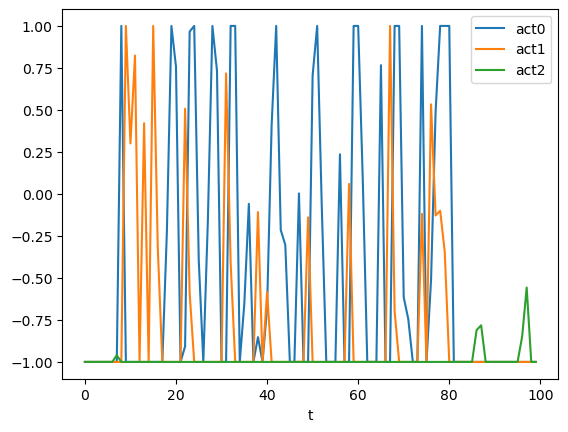

In [12]:
ppoData = simulator(env = evalEnv, agent = ppoAgent).simulate_full_named_obs_acts_time_series()
ppoDataDF = pd.DataFrame(ppoData)
display(ppoDataDF.head())
ppoDataDF[ppoDataDF.rep == 0].plot(x='t', y =['act0', 'act1', 'act2'])

<Axes: xlabel='t'>

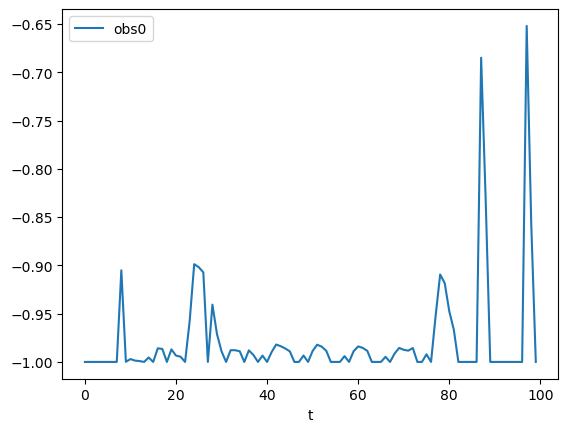

In [13]:
ppoDataDF[ppoDataDF.rep == 0].plot(x='t', y =['obs0'])